In [1]:
import openai
import os
import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from googlesearch import search
from docx import Document

import re
import requests
import nltk
import spacy

In [2]:
%cd ..

with open('private.txt', 'r') as f:
    content = f.read()
    key = re.findall(r'\'.*?\'', content)[0].strip('\'')
    openai.api_key = key
f.close()

%cd experiment    

h:\Andere Computer\Mein Computer\GoogleDrive\Beruf\Freelancing\Code_Repo\NLP_Text_Generation_Webapp
h:\Andere Computer\Mein Computer\GoogleDrive\Beruf\Freelancing\Code_Repo\NLP_Text_Generation_Webapp\experiment


# Utility

In [3]:
def parse_date_from_html(html_string):
    "parse date from html. Input html as byte object. The output is a string."
    try:
        regex = b"\d{4}-\d{2}-\d{2}" # b stands for byte like! not a string yet
        date = re.search(regex, html_string)[0]
        date_string = date.decode('utf-8') # turn to string
    except:
        try:
            regex = b"\d{4}\/\d{2}\/\d{2}" # b stands for byte like! not a string yet
            date = re.search(regex, html_string)[0]
            date_string = date.decode('utf-8')#.replace("/", "-") # turn to string
        except:
            date_string = 'no date detected'
    return date_string

def parse_title_from_html(html_string):
    "parse_title_from_html. Input html as byte object. The output is a string."
    try:
        title = re.search(b'<title>(.*?)</title>', html_string).group(1)
        title = title.decode('utf-8')
        title = title.split('.')[0].split('&')[0].split('|')[0].split('-')[0]
    except:
        title = 'no title detected'
    return title

def google_query(keywords, num_results=10):
  "query google by topics and return the url, the title and the publication date for each search result as lists"
  source_google = []
  titles_google = []
  publication_dates_google = []

  for kw in keywords:
    query = kw
    for url in search(query, num_results, lang="de"):
        # get html string
        html_string = requests.get(url).content     
        # get title
        title = parse_title_from_html(html_string)
        # get date
        date = parse_date_from_html(html_string)
        # save results in lists
        source_google.append(url)
        titles_google.append(title)
        publication_dates_google.append(date)

        print(url)  
        print(title)
        print(date)

  return source_google, titles_google, publication_dates_google

# Define Keywords

In [4]:
# define key words
keywords = ['Finanzielle Hilfe im Alter', 
            'Rentner in Not',
            'Armut Senioren',
            'Altersarmut Frauen',
            'Renten Pay-Gap',
            'Unterstützung Rentner']

# Generate Topic List 

## Generate Topics from Latest Article Headlines Found by Google Search

In [5]:
# get google search results for each topic
source_google, titles_google, publication_dates_google = google_query(keywords, num_results=10)

https://familienportal.de/familienportal/lebenslagen/alter/staatliche-leistungen
Staatliche Leistungen im Alter 
no date detected
https://www.caritas.de/hilfeundberatung/ratgeber/alter/pflege/finanzielle-hilfe-wenn-die-rente-nicht-reicht
Finanzielle Hilfe wenn die Rente nicht reicht
2021-10-04
https://www.kennstdueinen.de/magazin/geldnot-im-alter-welche-finanziellen-hilfen-gibt-es-wenn-die-rente-nicht-reicht/
Geldnot im Alter 
2015-09-04
https://www.seniorenlebenshilfe.de/dienstleistungen-fuer-senioren/grundsicherung-im-alter/
Wichtige Infos zur Grundsicherung im Alter 
2021-07-13
https://www.focus.de/finanzen/altersvorsorge/staatliche-unterstuetzung-viel-mehr-geld-im-alter-sieben-lohnende-zuschuesse-fuer-rentner_id_8970984.html
Viel mehr Geld im Alter: Sechs lohnende Zuschüsse für Rentner 
2018-05-25
https://www.serviceportal-zuhause-im-alter.de/wohnen/laenger-zuhause-wohnen/finanzielle-foerderung.html
Finanzielle Förderung 
no date detected
https://www.einherzfuerrentner.de/fuer-rent

In [6]:
#source_google = []
#titles_google = []
#publication_dates_google = []
len(publication_dates_google)

64

In [7]:
# turn titles and sources into dataframe
df_titles_google = pd.DataFrame({'source': source_google, 'title': titles_google, 'date': publication_dates_google})
df_titles_google.head(10)

,source,title,date
0,https://familienportal.de/familienportal/leben...,Staatliche Leistungen im Alter,no date detected
1,https://www.caritas.de/hilfeundberatung/ratgeb...,Finanzielle Hilfe wenn die Rente nicht reicht,2021-10-04
2,https://www.kennstdueinen.de/magazin/geldnot-i...,Geldnot im Alter,2015-09-04
3,https://www.seniorenlebenshilfe.de/dienstleist...,Wichtige Infos zur Grundsicherung im Alter,2021-07-13
4,https://www.focus.de/finanzen/altersvorsorge/s...,Viel mehr Geld im Alter: Sechs lohnende Zuschü...,2018-05-25
5,https://www.serviceportal-zuhause-im-alter.de/...,Finanzielle Förderung,no date detected
6,https://www.einherzfuerrentner.de/fuer-rentner/,Für Rentner,2023-02-27
7,https://www.ihre-vorsorge.de/magazin/lesen/wen...,Wenn das Geld im Alter nicht reicht: Finanziel...,2023-02-27
8,https://www.betanet.de/sozialhilfe-altenhilfe....,Sozialhilfe > Altenhilfe,no date detected
9,https://seniorenhilfe-lichtblick.de/,LichtBlick Seniorenhilfe e,2023-02-15


## Generate Topics Based on ChatGPT

In [8]:
instruction = \
"Nenne zu folgenden Keywords " + '\n' \
'keywords = ' + str(keywords)  + '\n' \
'20 Themenüberschriften.'
print('Instruction: ', instruction)

Instruction:  Nenne zu folgenden Keywords 
keywords = ['Finanzielle Hilfe im Alter', 'Rentner in Not', 'Armut Senioren', 'Altersarmut Frauen', 'Renten Pay-Gap', 'Unterstützung Rentner']
20 Themenüberschriften.


In [9]:
response = openai.Completion.create(
    engine="text-davinci-003",
    prompt=instruction,
    temperature=.5,
    max_tokens=1000,
    top_p=1,
    n=2,
    presence_penalty=.5,
    frequency_penalty=.5,
)

titles_chatgpt = response['choices'][0].text

# format titles and put into list
titles_chatgpt = [title.strip().replace("\n", "").replace(". ", "") for title in re.split(r'\d+', titles_chatgpt)]

In [10]:
# turn titles and sources into dataframe
date_today = datetime.date.today().strftime("%Y-%m-%d")
df_titles_chatgpt = pd.DataFrame({'source': 'chatgpt', 'title': titles_chatgpt, 'date': date_today})
df_titles_chatgpt.head(10)

,source,title,date
0,chatgpt,,2023-02-27
1,chatgpt,Finanzielle Unterstützung für Rentner in Not,2023-02-27
2,chatgpt,Wie wir Altersarmut bei Frauen bekämpfen können,2023-02-27
3,chatgpt,Wie Rentner den Pay-Gap überwinden können,2023-02-27
4,chatgpt,Wie wir Senioren vor Armut schützen können,2023-02-27
5,chatgpt,Warum finanzielle Hilfe im Alter so wichtig ist,2023-02-27
6,chatgpt,Ein Blick auf die Herausforderungen von Rentne...,2023-02-27
7,chatgpt,"Welche Möglichkeiten gibt es, um Altersarmut z...",2023-02-27
8,chatgpt,Der Kampf gegen die Renten Pay-Gap,2023-02-27
9,chatgpt,Lösungsansätze für Rentner in Not,2023-02-27


In [11]:
# concat both title dataframes
df_titles = df_titles_google.append(df_titles_chatgpt)
df_titles

C:\Users\Sebas\AppData\Local\Temp\ipykernel_21892\473715585.py:2: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_titles = df_titles_google.append(df_titles_chatgpt)


,source,title,date
0,https://familienportal.de/familienportal/leben...,Staatliche Leistungen im Alter,no date detected
1,https://www.caritas.de/hilfeundberatung/ratgeb...,Finanzielle Hilfe wenn die Rente nicht reicht,2021-10-04
2,https://www.kennstdueinen.de/magazin/geldnot-i...,Geldnot im Alter,2015-09-04
3,https://www.seniorenlebenshilfe.de/dienstleist...,Wichtige Infos zur Grundsicherung im Alter,2021-07-13
4,https://www.focus.de/finanzen/altersvorsorge/s...,Viel mehr Geld im Alter: Sechs lohnende Zuschü...,2018-05-25
...,...,...,...
16,chatgpt,Die Rolle der Politik beim Kampf gegen die Ren...,2023-02-27
17,chatgpt,Strategien zur Bekämpfung von Armut unter Seni...,2023-02-27
18,chatgpt,Wie man finanzielle Hilfe im Alter erhalten kann,2023-02-27
19,chatgpt,Erfolgreiche Maßnahmen zur Unterstützung von R...,2023-02-27


## Apply Topic-Keyword Similarity Filter

In [12]:
nlp = spacy.load("de_core_news_lg")

In [13]:
# measure similarity between the titles and the keywords
title_keyword_similarity = []
for title in df_titles['title']:
  sim_score = 0
  for kw in keywords:
    sim_score += nlp(title).similarity(nlp(kw)) / len(keywords) # average similarity score for better interpretability
  # append sum of similarity scores
  title_keyword_similarity.append(np.round(sim_score, 2))

C:\Users\Sebas\AppData\Local\Temp\ipykernel_21892\4193192492.py:6: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  sim_score += nlp(title).similarity(nlp(kw)) / len(keywords) # average similarity score for better interpretability


In [14]:
# Add title-keyword similarity scores to df_titles
df_titles['keyword_similarity'] = title_keyword_similarity
df_titles.head()

,source,title,date,keyword_similarity
0,https://familienportal.de/familienportal/leben...,Staatliche Leistungen im Alter,no date detected,0.40
1,https://www.caritas.de/hilfeundberatung/ratgeb...,Finanzielle Hilfe wenn die Rente nicht reicht,2021-10-04,0.40
2,https://www.kennstdueinen.de/magazin/geldnot-i...,Geldnot im Alter,2015-09-04,0.33
3,https://www.seniorenlebenshilfe.de/dienstleist...,Wichtige Infos zur Grundsicherung im Alter,2021-07-13,0.30
4,https://www.focus.de/finanzen/altersvorsorge/s...,Viel mehr Geld im Alter: Sechs lohnende Zuschü...,2018-05-25,0.39


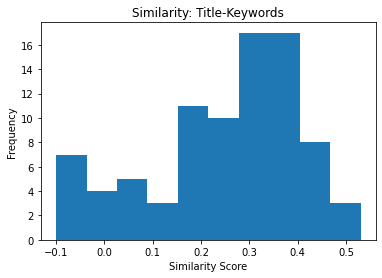

In [15]:
# show title-similarity distribution
plt.hist(df_titles['keyword_similarity'])
plt.title('Similarity: Title-Keywords')
plt.xlabel('Similarity Score')
plt.ylabel('Frequency')
plt.show()

In [16]:
# filter out similarity score < 0.1
df_titles = df_titles[df_titles['keyword_similarity'] > 0.1]
df_titles = df_titles.sort_values(by='keyword_similarity', ascending=False, ignore_index=True)
df_titles

,source,title,date,keyword_similarity
0,https://www.deutschlandfunkkultur.de/altersarm...,Altersarmut,2022-12-15,0.53
1,chatgpt,Finanzielle Unterstützung für Rentner in Not,2023-02-27,0.52
2,chatgpt,Lösungsansätze für Rentner in Not,2023-02-27,0.47
3,https://www.wn.de/muenster/immer-mehr-rentner-...,Immer mehr Rentner in Not,2022-10-07,0.46
4,https://frauen.verdi.de/themen/rente/++co++c0b...,Frauen haben niedrigere Renten – ver,no date detected,0.46
...,...,...,...,...
64,https://www.dza.de/detailansicht/im-arbeitsleb...,Im Arbeitsleben und im Ruhestand: gravierende ...,2022-10-18,0.18
65,https://www.malteser.de/dabei/information-tipp...,Altersarmut in Deutschland: Ein Überblick,no date detected,0.17
66,https://www.aktion-deutschland-hilft.de/de/fac...,Wie entsteht Altersarmut?,no date detected,0.14
67,https://www.libify.com/magazin/allgemein/entla...,Entlastungspaket 2022: Wie Rentner profitieren,2022-05-06,0.12


## Save Topic Ideation as Word Document

In [17]:
# create a word document 
document = Document()

# add table to document
table = document.add_table(rows=1, cols=4)
table.style = 'Table Grid'

# add table header
hdr_cells = table.rows[0].cells
hdr_cells[0].text = 'Source'
hdr_cells[1].text = 'Title'
hdr_cells[2].text = 'Date'
hdr_cells[3].text = 'Keyword Similarity'

# add data to table
for i in range(len(df_titles)):
    row_cells = table.add_row().cells
    row_cells[0].text = df_titles.iloc[i]['source']
    row_cells[1].text = df_titles.iloc[i]['title']
    row_cells[2].text = df_titles.iloc[i]['date']
    row_cells[3].text = str(df_titles.iloc[i]['keyword_similarity'])

# save word document
document.save('topic_ideation.docx')

# Advise ChatGPT to Write Article for Given Topic

In [18]:
topic = df_titles['title'][2]
print(topic)

Lösungsansätze für Rentner in Not


In [19]:
instruction = "\n" + \
"Schreibe einen Artikel von 250 Wörtern zum Thema: \n" + \
topic + '. \n' + \
"Der Artikel soll die Schlüsselbegriffe " + '\n' + \
str(keywords) + '\n' + \
"enthalten." + '\n' + \
"Desweiteren soll der Artikel in Absätze und Überschriften unterteilt sein." + '\n' + \
"Desweiteren sollen die Überschriften die Schlüsselbegriffe enthalten."

print('Instruction: ', instruction)

Instruction:  
Schreibe einen Artikel von 250 Wörtern zum Thema: 
Lösungsansätze für Rentner in Not. 
Der Artikel soll die Schlüsselbegriffe 
['Finanzielle Hilfe im Alter', 'Rentner in Not', 'Armut Senioren', 'Altersarmut Frauen', 'Renten Pay-Gap', 'Unterstützung Rentner']
enthalten.
Desweiteren soll der Artikel in Absätze und Überschriften unterteilt sein.
Desweiteren sollen die Überschriften die Schlüsselbegriffe enthalten.


In [20]:
response = openai.Completion.create(
    engine="text-davinci-003",
    prompt=instruction,
    temperature=.5,
    max_tokens=1000,
    top_p=1,
    n=2,
    presence_penalty=.5,
    frequency_penalty=.5,
)

text_seo = response['choices'][0].text

In [21]:
print(text_seo)



Lösungsansätze für Rentner in Not 

Rentner in Not sind ein wachsendes Problem. Diese Situation kann aufgrund des Pay-Gaps, der Armut bei Senioren und der Altersarmut bei Frauen weiter verschärft werden. Daher ist es wichtig, dass Lösungsansätze gefunden werden, um den Rentnern zu helfen. 

Finanzielle Hilfe im Alter 
Eine Möglichkeit, Rentnern in Not zu helfen, besteht darin, ihnen finanzielle Unterstützung zukommen zu lassen. Es gibt viele Programme und Initiativen, die Senioren mit niedrigem Einkommen helfen können. Zum Beispiel können sie Anspruch auf staatliche Leistungen oder Ermäßigungen haben. Auch private Organisationen bieten oft Unterstützung an, zum Beispiel in Form von Spendengeldern oder speziell für ältere Menschen gedachten Stiftungsfonds. 

Unterstützung Rentner 
Eine andere Möglichkeit besteht darin, den Senioren direkte Unterstützung anzubieten. Dies kann in Form von Mahlzeitendiensten erfolgen, die den Betroffenen Essensmarken oder Lebensmittelpakete liefern; es k

## Save SEO Text as Word Document

In [22]:
# Create a new document object.
document = Document()

# Create a new paragraph object.
paragraph = document.add_paragraph()

# Write the string to the paragraph object.
paragraph.add_run(text_seo)

# Save the document.
document.save('seo_text.docx')

# ToDo

- Include Keywords into article generation -> ok
- Add column with publication date! -> ok
- Save Topic List and hand over to Alexa -> warte auf Feedback
- correct topic titles
- code review: make functions
- develop streamlit app